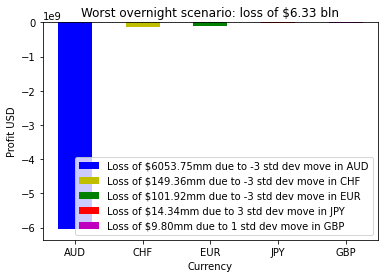

In [88]:
"""PF: Value at Risk
For: OMSBA 5061, Seattle University
Author: Andrew Nalundasan
Date: 11/24/2020
### Look for guidance notes that start with the triple-hash comments
"""
### Here's what the imports look like in our solution:
from datetime import date, timedelta
from itertools import product

import pandas as pd
import pylab
import numpy as np

from p5_fx_option import fx_option_price
###

### Following is the entire FxPosition class. This will handle the spot positions in each currency.
### You'll also want to create a subclass FxOption for the option positions -- see below.
class FxPosition(object):
    """Class for a spot position in a foreign currency.
    This is also the base class for more complex foreign exchange contracts, like FxOption.
    """

    def __init__(self, quantity, foreign, domestic='USD'):
        """
        Construct a position in foreign exchange.
        :param quantity: number of units of the foreign currency
        :param foreign: 3-character ISO code for the foreign currency, e.g., 'gbp'
        :param domestic: 3-character ISO code for the home currency, defaults to 'USD'
        """
        self.quantity = quantity  # units of foreign currency
        self.foreign = foreign.upper()
        self.domestic = domestic.upper()

    def __repr__(self):
        """Representation
        >>> FxPosition(3202.0220, 'gbp')
        FxPosition(3202.022, 'GBP')
        >>> FxPosition(1_000, 'gbp', 'chf')
        FxPosition(1000, 'GBP', 'CHF')
        """
        return "%s(%s, %r%s)" % (self.__class__.__name__, self.quantity, self.foreign,
                                 ", %r" % self.domestic if self.domestic != 'USD' else '')

    def __str__(self):
        """As string
        >>> print(FxPosition(3202.0220, 'gbp'))
        3202.02 GBP
        >>> print(FxPosition(1_000, 'gbp', 'chf'))
        1000.00 GBP
        """
        return "%.2f %s" % (self.quantity, self.foreign)

    def quoting_convention(self):
        """Returns the currency, either self.foreign or self.domestic, which is the currency whose
        quantity is quotes in spot exchange rates for this currency pair.
        >>> FxPosition(100, 'GBP').quoting_convention()
        'USD'
        >>> FxPosition(100, 'JPY').quoting_convention()
        'JPY'
        >>> FxPosition(100, 'JPY', 'EUR').quoting_convention()  # we'd need a chart to do these right...
        'EUR'
        """
        if self.domestic == 'USD' and self.foreign not in ('GBP', 'EUR', 'AUD', 'NZD'):
            return self.foreign  # prices are foreign units per domestic unit, e.g., 103.2 yen per dollar
        else:
            return self.domestic  # prices are domestic units per foreign unit, e.g. 1.49 dollars per pound sterling

    def price(self, spot, spot_date=date.today(), volatility=0.0, domestic_rate=0.0, foreign_rate=0.0):
        """Return the value in self.domestic units of self.quantity of self.foreign unit.
        The spot parameter is the market-quoted exchange rate (for one unit of currency).
        The other parameters are ignored here, though they may not be in subclasses.
        >>> FxPosition(1000, 'GBP', 'USD').price(1.25)
        1250.0
        >>> FxPosition(25000, 'JPY', 'USD').price(100.0)
        250.0
        """
        if self.quoting_convention() == self.domestic:
            return self.quantity * spot
        else:
            return self.quantity * 1 / spot
### End of provided FxPosition class


### For the options, we start with the FxPosition class and override the constructor,
### __repr__, __str__, and price methods. We've given you the docstrings.
class FxOption(FxPosition):
    """Models a foreign exchange option contract."""

    def __init__(self, quantity, call_put, strike, expiration, foreign, domestic='USD'):
        """
        Constucts a forex option
        :param quantity:    number of units of foreign currency in contract (can be negative for short position)
        :param call_put:    refers to the foreign currency units
        :param strike:      number of units to exchange if exercised (same units as spot rate for this currency pair)
        :param expiration:  date on optional exchange
        :param foreign:     ISO code for the currency units being optioned
        :param domestic:    ISO code for the payment currency
        """
        super(FxOption, self).__init__(quantity, foreign, domestic)  # this calls the superclass's constructor
        
        ### FIXME: fill in your code here
        call_put_lower = call_put.lower()
        self.call_put = True if call_put_lower == 'call' or call_put_lower == 'c' else False
        self.strike = strike
        self.expiration = expiration

    def __repr__(self):
        """Representation
        >>> FxOption(3202.0220, 'c', 1.5, date(2019, 4, 18), 'gbp')
        FxOption(3202.022, 'call', 1.5, datetime.date(2019, 4, 18), 'GBP')
        """
        """personal doctest for repr():
        >>> FxOption(3202.0220, 'p', 1.5, date(2019, 4, 18), 'jpy')
        FxOption(3202.022, 'put', 1.5, datetime.date(2019, 4, 18), 'jpy')
        """
        ### FIXME: implement this
    
        return "%s(%s, %s, %.1f, %s, %r%s)" % (self.__class__.__name__, self.quantity,
                                               "'call'" if self.call_put else "'put'",
                                               self.strike, repr(self.expiration), self.foreign,
                                               ", %r" % self.domestic if self.domestic != 'USD' else '')

    def __str__(self):
        return repr(self)

    def price(self, spot, spot_date=date.today(), volatility=0.15, domestic_rate=0.03, foreign_rate=0.03):
        """Return the value of the contract in self.domestic units.
        >>> option = FxOption(1_000_000, 'call', 152, date(2019, 7, 1), 'NZD')
        >>> '%.4f' % option.price(150, date(2019, 4, 1), 0.13, 0.03, 0.04)
        '2811044.5343'
        >>> option = FxOption(1_000_000, 'put', 152, date(2019, 7, 1), 'NZD')
        >>> '%.4f' % option.price(150, date(2019, 4, 1), 0.13, 0.03, 0.04)
        '5166865.0332'
        >>> option = FxOption(10_000, 'put', 108, date(2019, 7, 1), 'JPY')
        >>> '%.10f' % option.price(108.38, date(2019, 4, 1), 0.0638, 0.0231988, -0.006550)
        '1.0009154473'
        >>> FxOption(0, 'c', 0, date.today(), 'XYZ').price(0, date.today(), 0, 0, 0)
        0.0
        """
        ### remember to invert the spot and strike, if necessary, before calling fx_option_price
        ### FIXME: implement this to call fx_option_price
        
        # invert when quoting_convention != domestic

        if (volatility == 0 or spot_date >= self.expiration):            # avoid scenarios where x / 0
            return 0.0

        should_invert = self.domestic != self.quoting_convention()       # invert rule

        strike_to_use = 1 / self.strike if should_invert else self.strike   # this follows the invert rule from super.price()
        spot_to_use = 1 / spot if should_invert else spot                    # this follows the invert rule from super.price()

        # call fx_option_price function from P5 program
        option_price = fx_option_price(call = self.call_put, strike = strike_to_use, expiration = self.expiration,
                                       spot_date = spot_date, spot = spot_to_use, volatility = volatility,
                                       domestic_rate = domestic_rate, foreign_rate = foreign_rate)

        return self.quantity * option_price     # this gives us (quantity * option price)


### We use the Scenario class to get the profits for each of the 3125 scenarios (one object with 3125 calls to
### its profit method).
class Scenario(object):
    """Class to calculate profits for a given scenario."""

    def __init__(self, positions, spots, vols, rates):
        """
        Construct a Scenario with given:
        :param positions:  list of objects that have a method, price, and a data attribute, foreign
        :param spots:      dict of spot exchange rates for today versus USD (quoted in standard market conventions)
        :param vols:       dict of volatilities for each exchange rate
        :param rates:      dict of 3-month rates used to pass to price method for positions (must include 'USD' key)
        """
        ### FIXME: implement this  (use date.today() as spot date)
        
        self.positions = positions
        self.spots = spots
        self.vols = vols
        self.rates = rates
        self.spot_date = date.today()
        

    def profit(self, moves):
        """
        Compute profit in USD of positions tomorrow given the specified moves.
        Returns a dictionary of the profits broken down by currency and also with a 'Total'.
        :param moves:      number of standard deviations to move spot by tomorrow in scenario
        ### Note that your tests below might be off in the least significant places.
        >>> positions = [FxPosition(100, 'GBP'), FxPosition(10_000, 'JPY')]
        >>> spots = {'GBP': 1.5, 'JPY': 100.0}
        >>> vols = {'GBP': 0.1, 'JPY': 0.1}
        >>> rates = {'GBP': 0.03, 'JPY': 0.0, 'USD': 0.02}
        >>> Scenario(positions, spots, vols, rates).profit({'GBP': 0, 'JPY': 0})
        {'GBP': 0.0, 'JPY': 0.0, 'Total': 0.0}
        >>> positions.append(FxOption(-100_000, 'c', 1.123, date.today() + timedelta(days=90), 'GBP'))
        >>> sc = Scenario(positions, spots, vols, rates)
        >>> sc.profit({'GBP': 0, 'JPY': 0})
        {'GBP': -6.1150852480423055, 'JPY': 0.0, 'Total': -6.1150852480423055}
        >>> sc.profit({'GBP': -3, 'JPY': 1})
        {'GBP': 36911.059057459956, 'JPY': -9.090909090909108, 'Total': 36901.968148369044}
        """
        
        ### FIXME: implement this by calling compute_valuation with current spots, then again with
        ###             spots moved according to given moves. Volatility = one standard deviation, so
        ###             for example, a move of -1 would be spot *= (1 - vol).
        
        new_spots = {}        # create empty dictionary for new_spots
        valuation_today = self.compute_valuation(self.spots)        # check for available positions with current spots
        for position in self.positions:         # check for available positions
            current_spot = self.spots[position.foreign]        # this gets us the current spot
            move_to_make = moves[position.foreign]             # this gets us the move to make
            vol = self.vols[position.foreign]                  # this gets us volatility
            stdev_delta = 1.0 + (move_to_make * vol)        # std dev = 1 + (move * vol)
            new_spots[position.foreign] = current_spot * stdev_delta        # saving the new spot at right std dev level
        valuation_tomorrow = self.compute_valuation(new_spots, timedelta(1))    # call compute valuation for 'Tomorrow'
        total_profits = {}        # empty dictionary for total_profits
        total = 0.0               # initialize at 0 to increment to
        for key in valuation_tomorrow:        # better to iterate over valid keys rather than filtering out from positions
            profit_per_position = valuation_tomorrow[key] - valuation_today[key]    # profit in whatever currency
            total += profit_per_position        # increment total
            total_profits[key] = profit_per_position        # dump result of this into dictionary for currency to get type
        total_profits['Total'] = total        # append to existing dictionary
        return total_profits
        ### FIXME: implement this by calling compute_valuation with current spots, then again with
        ###             spots moved according to given moves. Volatility = one standard deviation, so
        ###             for example, a move of -1 would be spot *= (1 - vol).
    
    def compute_valuation(self, spots, spot_date_delta=timedelta(0)):
        """Return a dictionary keyed by foreign currency of values in USD of positions with given spots
        on self.spot_date + spot_date_delta. Uses vols and rates from self.
        """
        result = {}        # initialize empty dictionary for 'result'
        for position in self.positions:        # this is for all positions, even when exchange doesn't happen between same currency
            vol = self.vols[position.foreign]              # this gets us volatility    
            f_rate = self.rates[position.foreign]          # this gets us the foreign_rate
            d_rate = self.rates[position.domestic]         # this gets us domestic_rate. default domestic_rate = 'usd'
            spot = spots[position.foreign]                 # this gets us the spot
            
            # if many positions with same currency type, sum everything together
            # initialize bucket to 0 as needed
            if position.foreign not in result:
                result[position.foreign] = 0.0
            
            # this adds 'price' to the correct position in dictionary
            # don't zero out current calculated price. ok if same currency
            result[position.foreign] += position.price(spot = spot,
                                             spot_date = self.spot_date + spot_date_delta,
                                             volatility = vol,
                                             domestic_rate = d_rate,
                                             foreign_rate = f_rate)
        return result
        
       
### FUNCTIONS:

def load_data(filename):
    """Get the data from the given csv file.
    Returns: positions, spots, volatilities, rates
    """
    ### load_data uses pandas to read in the csv file and extract the columns
    ### Example of extracting a column from pandas data frame
    
    ### FIXME: implement
    
    # solve for volatilities and rates
    ccy_data = pd.read_csv(filename)        # read in csv file using pandas as pd
    currencies = ccy_data['currency']       # get all the currencies from the file
    spots = dict(zip(currencies, ccy_data['spot exchange rate']))        # taken from example
    volatilities = dict(zip(currencies, ccy_data['3-month volatility (annualized)']))        # this maps each volatility to type of currency
    rates = dict(zip(currencies, ccy_data['3-month interest rate (annualized)']))        # this maps each rate to type of currency
    
    # solve for positions
    positions = []    # create empty list for positions
    spot_positions = dict(zip(currencies, ccy_data['spot position']))
    call_option_positions = dict(zip(currencies, ccy_data['call option position']))
    put_option_positions = dict(zip(currencies, ccy_data['put option position']))
    
    # equation for all currencies but not USD
    for ccy in currencies:
        if ccy == 'USD':
            continue
        strike = spots[ccy]        # get spot exchange rate
        expiration = date.today() + timedelta(90)        # 90 days = 3 month expiration date and 3 month interest rate
        positions.append(FxPosition(spot_positions[ccy], ccy))        # append spot position
        positions.append(FxOption(call_option_positions[ccy], 'c', strike, expiration, ccy))    # append call option position
        positions.append(FxOption(put_option_positions[ccy], 'p', strike, expiration, ccy))     # append put option position
    
    return positions, spots, volatilities, rates
    
def extremeness(moves):
    """Get the 'severity' of the moves--sum of absolute values of moves.
    >>> extremeness((3, -2, 0, 1))
    6
    """
    ### FIXME: implement
    
    total_sum = 0        # initialize result
    for move in moves:
        total_sum += abs(move)        # total each move using absolute value
    
    return total_sum

def plot_scenario(profits, moves):
    """Plot a mixed-color bar chart as specified by management in PF: Data Translator Final Project."""
    ### FIXME: implement
    pylab.figure(1)        # create new figure using pylab called "Figure 1"
    colors = ['b', 'y', 'g', 'r', 'm']        # list of possible colors
    bar_heights = []        # list for height of bars
    bar_labels = []         # list for labels of bars (abbrev of 'currency')
    legend_labels = []      # list for legend for labels
    for key in sorted(profits, key = profits.get):
        if key == 'Total':        # this skips 'Total'
            continue
        bar_heights.append(profits[key])        # append as bar height
        bar_labels.append(key)        # append abbrev for 'currency' as label for bar
        legend_labels.append("Loss of $%.2fmm due to %d std dev move in %s" % (-profits[key] / 1000000.0,
                                                                             moves[key], key))
    
    x = np.arange(len(bar_labels))        # locations of the labels
    width = 0.5       # width of bars
    
    chart = pylab.bar(x, bar_heights, width, color = colors)        # creates chart
    pylab.legend(chart.patches, legend_labels, loc = 'lower right')  # creates legend and places in lower right corner
    total = -profits['Total']        # total
    
    # logic for title of chart
    if total < 1000000000.0:        # if total is less than 1 bn
        pylab.title("Worst overnight scenario: loss of $%.2f mln" % (total / 1000000.0))
    else: 
        pylab.title("Worst overnight scenario: loss of $%.2f bln" % (total / 1000000000.0))
    
    # logic for labels
    pylab.xlabel('Currency')       # this labels x-axis
    pylab.xticks(x, bar_labels)    # this labels tick marks on x-axis
    pylab.ylabel('Profit USD')     # this labels y-axis
    
    pylab.show()        # python has built it, now i must show it
    

def produce_report(data_set_name):
    """Load the data from the currency_data file, calculate all the scenarios (3125 of them if there
    are five non-USD currencies), pick the worst of these (biggest loss) and plot it.
    """
    ### excerpts from the start of this function:
    
    positions, spots, volatilities, rates = load_data('pf_%s_currency_data.csv' % data_set_name)    # provided with guidance
    scenario = Scenario(positions, spots, volatilities, rates)        # provided with guidance
    move_choices = (-3, -1, 0, 1, 3)        # provided with guidance
    
    currencies = []    ### list of non-USD currencies
    for ccy in rates:        # this gets list of currencies NOT 'usd'
        if ccy.upper() != 'USD':
            currencies.append(ccy)
    
    results = []        # initialize empty list
    for moves in product(move_choices, repeat=len(currencies)):        # provided with guidance
        moves_to_use = {}        # initialize empty dictionary for moves
        for i in range(len(moves)):        # map non-usd currency with corresponding move
            moves_to_use[currencies[i]] = moves[i]
            
        extreme = extremeness(moves)                  # this calculates extreme
        profit = scenario.profit(moves_to_use)        # this calculates profit
        results.append((profit['Total'], extreme, profit, moves_to_use))        # append information needed for plots
          
    ### FIXME: sort the results by worst loss and extremeness, then pick the worst, then call plot_scenario
    results.sort()            # this sorts the results
    worst = results[0]        # this gets the worst loss
    plot_scenario(worst[2], worst[3])        # this plots the scenario with worst choices
    

if __name__ == '__main__':
    produce_report('test1')  ### this should produce results as shown in Canvas
    # produce_report('test2')  ### verify yourself that this produces the correct results
    # produce_report('test3')  ### used by grader
    # produce_report('test4') # andrew created another file for test4 


In [75]:
positions = [FxPosition(100, 'GBP'), FxPosition(10_000, 'JPY')]
spots = {'GBP': 1.5, 'JPY': 100.0}
vols = {'GBP': 0.1, 'JPY': 0.1}
rates = {'GBP': 0.03, 'JPY': 0.0, 'USD': 0.02}
Scenario(positions, spots, vols, rates).profit({'GBP': 0, 'JPY': 0})

{'GBP': 0.0, 'JPY': 0.0, 'Total': 0.0}

In [76]:
positions.append(FxOption(-100_000, 'c', 1.123, date.today() + timedelta(days=90), 'GBP'))
sc = Scenario(positions, spots, vols, rates)
sc.profit({'GBP': 0, 'JPY': 0})

{'GBP': -6.1150852480423055, 'JPY': 0.0, 'Total': -6.1150852480423055}

In [77]:
sc.profit({'GBP': -3, 'JPY': 1})

{'GBP': 36911.059057459956,
 'JPY': -9.090909090909108,
 'Total': 36901.968148369044}